#Goal

machine learning model that can accurately predict whether a person has diabetes based on their provided features


The features in the dataset are as follows:

- Pregnancies: Number of pregnancies the individual has had

- Glucose: 2-hour plasma glucose concentration in the oral glucose tolerance test

- Blood Pressure: Blood pressure (in mm Hg)

- SkinThickness: Thickness of the skinfold

- Insulin: 2-hour serum insulin concentration (mu U/ml)

- DiabetesPedigreeFunction: Diabetes pedigree function, indicating family history of diabetes

- BMI: Body mass index

- Age: Age in years

- Outcome: Whether the individual has diabetes (1) or not (0)

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [7]:
!pip install lightgbm

In [135]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import plotly.graph_objects as go
import time
import kagglehub as kh

from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, export_text
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn import metrics
from sklearn.metrics import classification_report, r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit, StratifiedKFold, cross_validate, validation_curve, RandomizedSearchCV
from sklearn.impute import KNNImputer


import warnings

warnings.simplefilter(action="ignore")

#Adjusting Row Column Settings

In [30]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.float_format", lambda x: '%.3f' % x)

#load data

In [20]:
filepath = kh.dataset_download("mathchi/diabetes-data-set")

100%|██████████| 8.91k/8.91k [00:00<00:00, 13.3MB/s]

Extracting files...


In [21]:
path = os.path.join(filepath, os.listdir(filepath)[0])

In [22]:
df = pd.read_csv(path)

# Exploratory Data Analysis

In [34]:
def check_df(df, head=5):
  print("Shape...............................................")
  print(df.shape)
  print("")
  print("Data types...............................................")
  print(df.dtypes)
  print("")
  print("Head...............................................")
  print(df.head(head))
  print("")
  print("Tail...............................................")
  print(df.tail(head))
  print("")
  print("Null values...............................................")
  print(df.isnull().sum())
  print("")
  print("Quantiles...............................................")
  print(df.quantile([0,0.05,0.50, 0.95, 0.99, 1 ]).T)


check_df(df)

Shape...............................................
(768, 9)

Data types...............................................
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Head...............................................
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  \
0            6      148             72             35        0 33.600                     0.627   
1            1       85             66             29        0 26.600                     0.351   
2            8      183             64              0        0 23.300                     0.672   
3            1       89             66             23       94 28.100                     0.

#Capturing / Detecting Numeric and Categorical Variables

In [35]:
def identify_dtype_of_columns(df, cat_th=10, car_th=20):

  cat_cols = [col for col in df.columns if df[col].dtypes == "O" ]
  num_but_cat_cols = [col for col in df.columns if df[col].dtypes != "O" and df[col].nunique() < cat_th ]
  cat_but_car_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() > car_th ]

  cat_cols = cat_cols + num_but_cat_cols

  cat_cols = [col for col in cat_cols if col not in cat_but_car_cols ]

  num_cols = [col for col in df.columns if df[col].dtypes != "O"  ]

  num_cols = [col for col in num_cols if col not in num_but_cat_cols ]

  print(f"Observations: {df.shape[0]}")
  print(f"Variables: {df.shape[1]}")
  print(f"cat_cols: {len(cat_cols)}")
  print(f"num_cols: {len(num_cols)}")
  print(f"cat_but_car_cols: {len(cat_but_car_cols)}")
  print(f"num_but_cat_cols: {len(num_but_cat_cols)}")

  return cat_cols, cat_but_car_cols, num_cols, num_but_cat_cols

In [36]:
cat_cols, cat_but_car_cols, num_cols, num_but_cat_cols = identify_dtype_of_columns(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car_cols: 0
num_but_cat_cols: 1


In [37]:
print("cat_cols", cat_cols)
print("cat_but_car_cols", cat_but_car_cols)
print("num_cols", num_cols)
print("num_but_cat_cols", num_but_cat_cols)

cat_cols ['Outcome']
cat_but_car_cols []
num_cols ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
num_but_cat_cols ['Outcome']


# Analysis of Categorical Variables

In [38]:
def cat_summary(df, col_name, plot=False):
  print(pd.DataFrame({"col_name": df[col_name].value_counts(), "Ratio":100*df[col_name].value_counts()/len(df)}))
  print(" ")
  print(".................................")
  print(" ")

  if plot:
    sns.countplot(x=df[col_name], data=df)
    plt.show(block=True)

         col_name  Ratio
Outcome                 
0             500 65.104
1             268 34.896
 
.................................
 


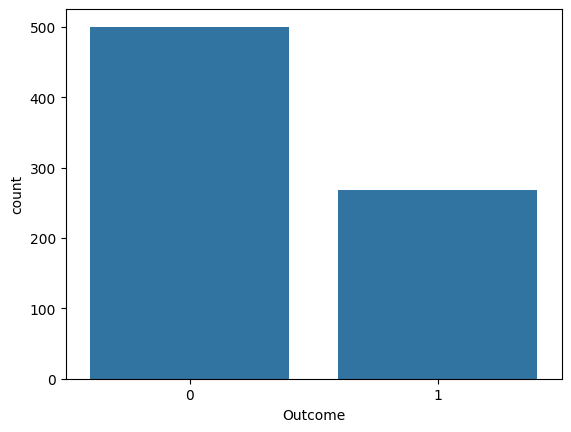

In [40]:
for col in cat_cols:
  cat_summary(df, col, True)

# Analysis of Numerical Variables

In [41]:
def num_summary(df, num_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(df[num_col].describe(quantiles).T)

  if plot:
    df[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)


count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


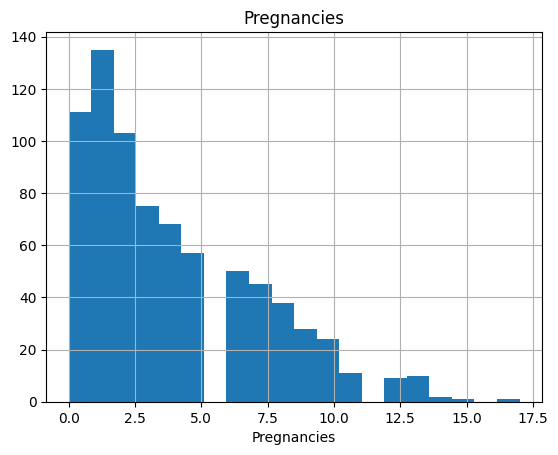

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


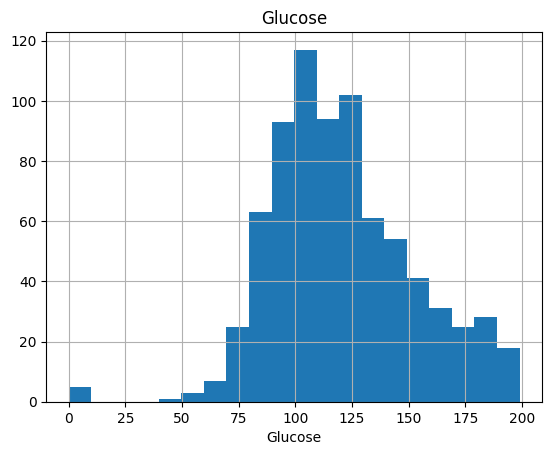

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


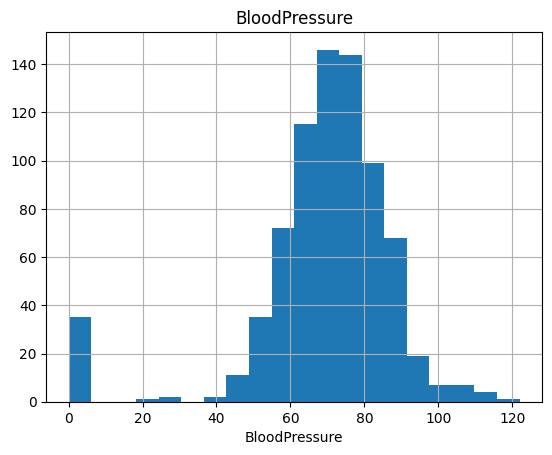

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


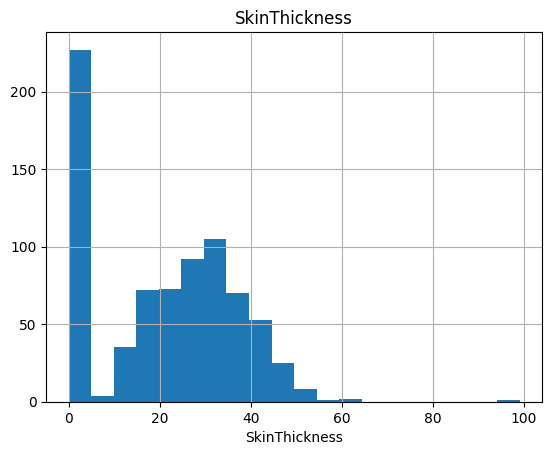

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


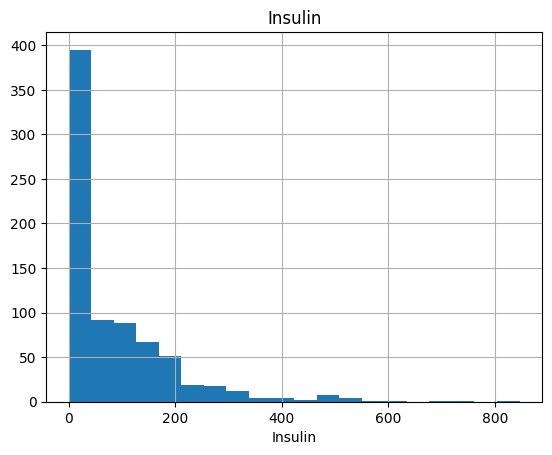

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


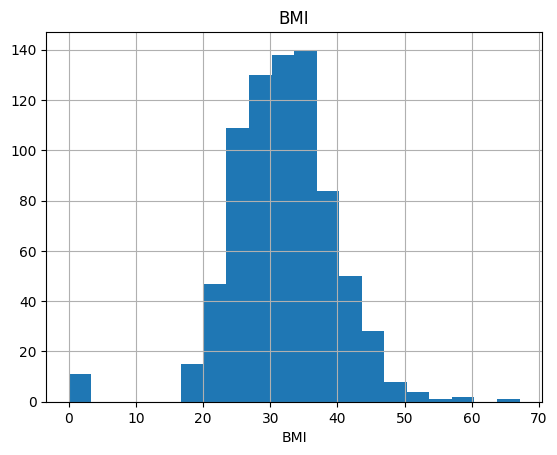

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


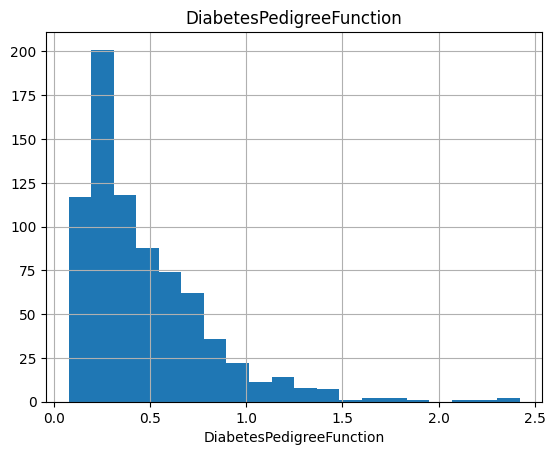

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


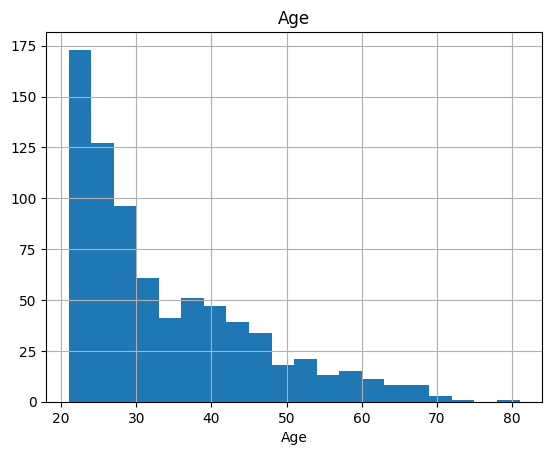

In [42]:
for col in num_cols:
  num_summary(df, col, True)

# Analysis of Categorical Variables by Target

In [43]:
def target_summary_with_cat(df, target, cat_col, plot=False):
  print(pd.DataFrame({"Target_Mean": df.groupby(cat_col)[target].mean()}), end="\n\n\n")

  if plot:
    sns.barplot(x=cat_col, y=target, data=df)
    plt.show(block=True)

         Target_Mean
Outcome             
0              0.000
1              1.000




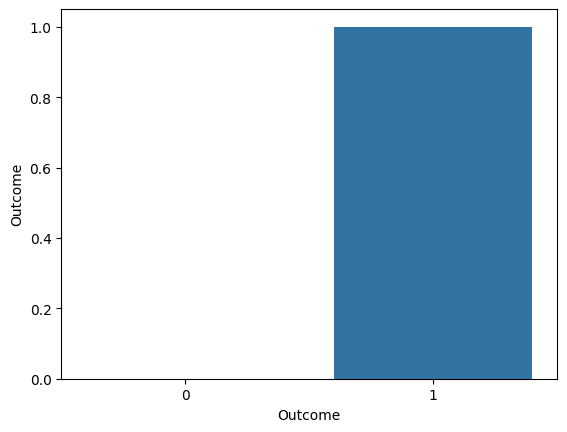

In [44]:
for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col, plot=True)

# Analysis of Numeric Variables by Target

In [45]:
def target_summary_with_num(df, target, num_col, plot=False):
    print(pd.DataFrame({num_col+'_mean': df.groupby(target)[num_col].mean()}), end='\n\n\n')

    if plot:
        sns.barplot(x=target, y=num_col, data=df)
        plt.show(block=True)

         Pregnancies_mean
Outcome                  
0                   3.298
1                   4.866




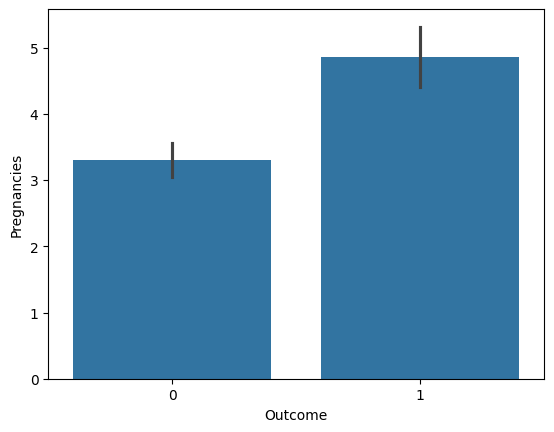

         Glucose_mean
Outcome              
0             109.980
1             141.257




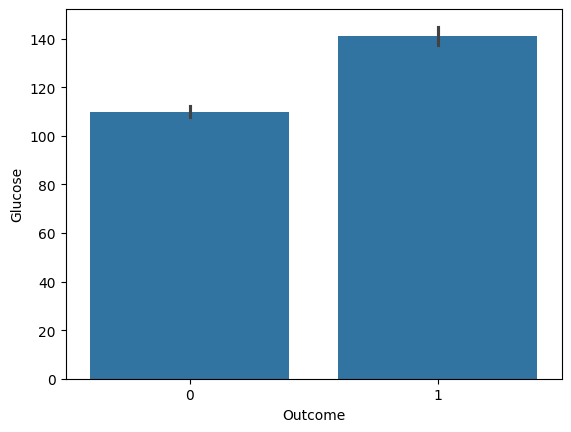

         BloodPressure_mean
Outcome                    
0                    68.184
1                    70.825




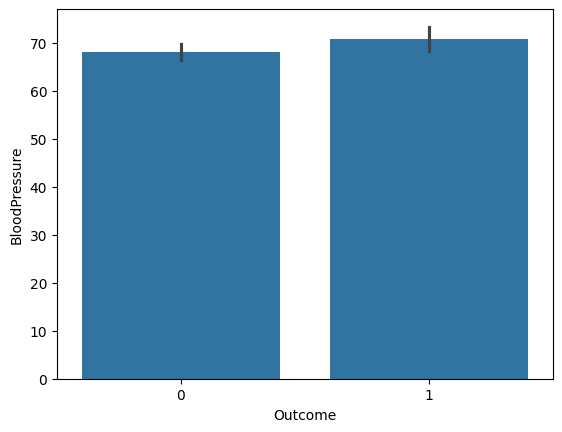

         SkinThickness_mean
Outcome                    
0                    19.664
1                    22.164




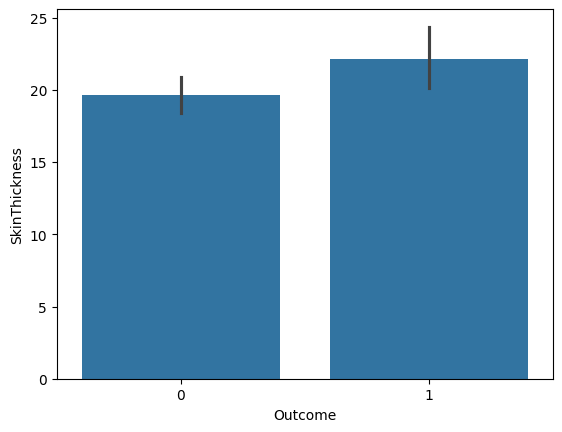

         Insulin_mean
Outcome              
0              68.792
1             100.336




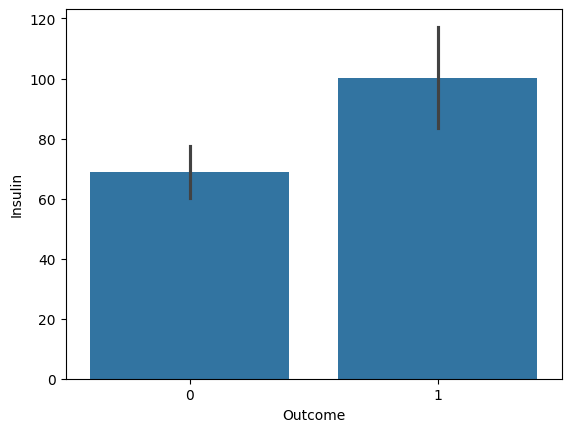

         BMI_mean
Outcome          
0          30.304
1          35.143




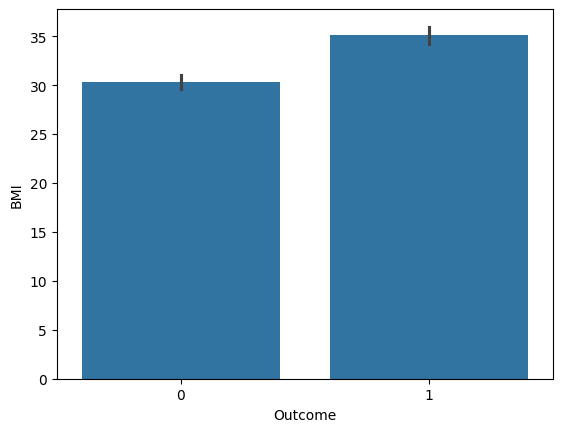

         DiabetesPedigreeFunction_mean
Outcome                               
0                                0.430
1                                0.550




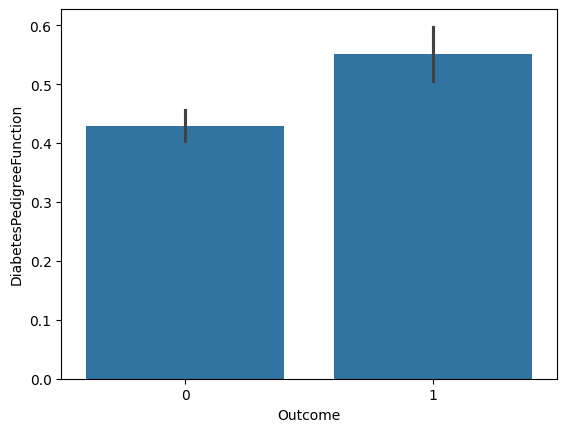

         Age_mean
Outcome          
0          31.190
1          37.067




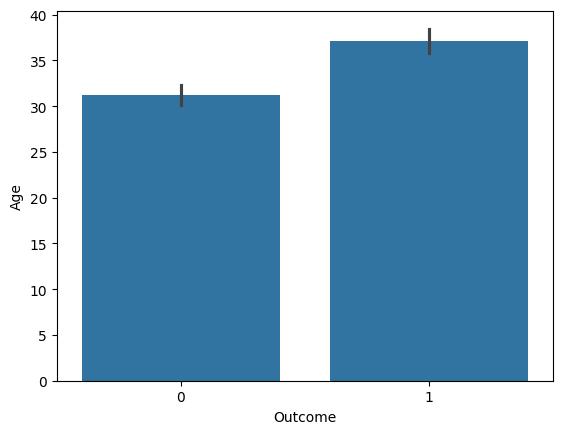

In [46]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col, plot=True)

# Correlation Analysis

In [47]:
corr= df.corr()

In [48]:
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


In [51]:
def high_corr_cols(df, plot=False, corr_th=0.70):
  corr= df.corr()
  cor_matrix= corr.abs()
  upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangle_matrix if any(upper_triangle_matrix[col]>corr_th)]

  if plot:
    sns.set(rc={"figure.figsize": (8, 8)})
    corr_values = corr.round(2)
    sns.heatmap(corr, cmap="RdBu", annot=corr_values)
    plt.show(block=True)

  return drop_list

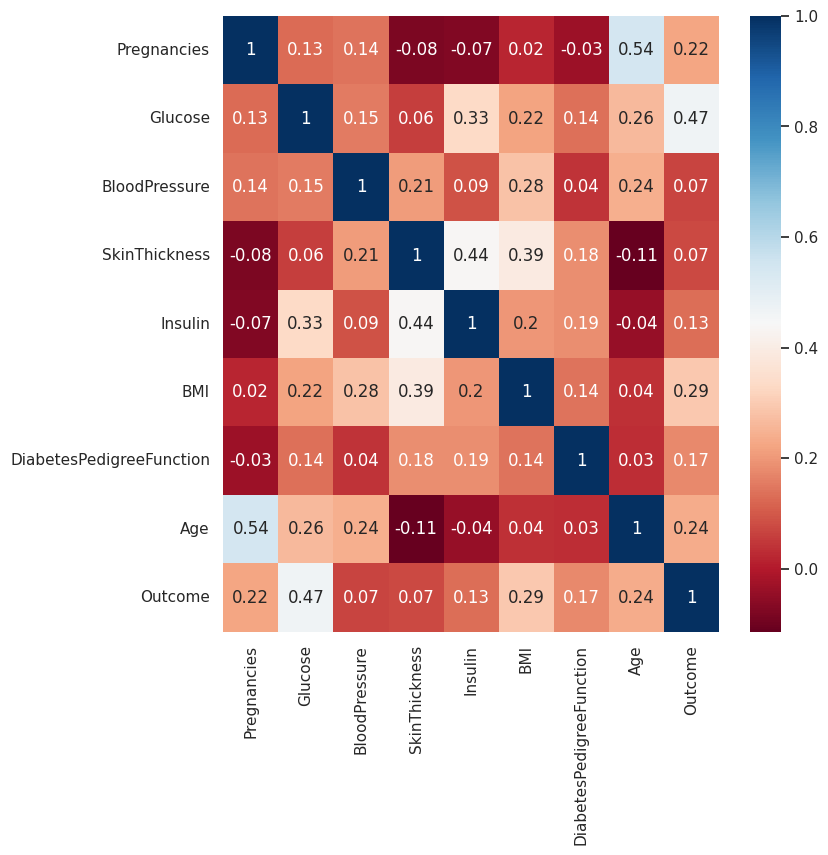

[]

In [52]:
high_corr_cols(df, plot=True)

# The Relationship Between Variables

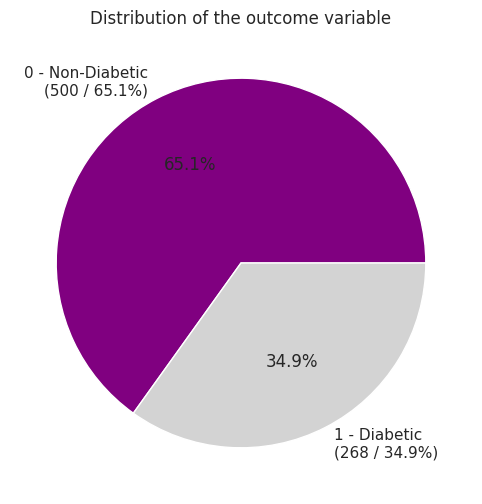

In [53]:
outcome_count = df["Outcome"].value_counts()

total_patients = outcome_count.sum()

percentages = outcome_count/total_patients *100

labels = [f'0 - Non-Diabetic\n({outcome_count[0]} / {percentages[0]:.1f}%)',
          f'1 - Diabetic\n({outcome_count[1]} / {percentages[1]:.1f}%)']

plt.figure(figsize=(8,6))
plt.pie(outcome_count, labels = labels, autopct="%1.1f%%", colors=["purple", "lightgray"])
plt.title("Distribution of the outcome variable")
plt.show(block=True)

In [54]:
feature_combinations = list(itertools.combinations(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], 2))

for i, (feature1, feature2) in enumerate(feature_combinations):
    fig = px.scatter(df, x=feature1, y=feature2, color='Outcome', size='BMI',
                     title=f'{feature1} vs {feature2} Bubble Chart')

    fig.show(block=True)

#Outlier Analysis

In [55]:
def outlier_threshold(df, col, q1=0.05, q3=0.95):
  quartiel1 = df[col].quantile(q1)
  quartiel3 = df[col].quantile(q3)

  iqr = quartiel3-quartiel1

  upper_limit = quartiel3+1.5*iqr
  lower_limit = quartiel1-1.5*iqr

  return lower_limit, upper_limit

In [56]:
def check_outlier(df, col, plot=False):

  lower_limit, upper_limit = outlier_threshold(df, col)

  outliers = df[(df[col]> upper_limit) | (df[col]< lower_limit)]

  if outliers.any(axis=None):
    if plot:
      plt.figure(figsize=(8,6))
      sns.baxplot(x=df[col])
      plt.title(f"Outlier in {col}")
      plt.show()
    return True
  return False


In [57]:
def replace_with_thresholds(df, variable, q1=0.05, q3=0.95):
  lower_limit, upper_limit = outlier_threshold(df, variable)
  df.loc[(df[variable] < lower_limit), variable] = lower_limit
  df.loc[(df[variable] > upper_limit), variable] = upper_limit


In [58]:
for col in df.columns:
    print(col, check_outlier(df, col, plot=False))
    if check_outlier(df, col, plot=False):
        replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [59]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.637,114.243,0.000,0.000,30.500,127.250,732.500
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


# Missing Value Analysis

In [61]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [64]:
zero_columns= [col for col in df.columns if (df[col].min()==0 ) and col not in ["Pregnancies", "Outcome"]]

In [65]:
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [66]:
for i in zero_columns:
  df[col] = np.where(df[col]==0, np.nan, df[col])

In [67]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,500


In [68]:
def missing_values_table(df, na_name=False):
  na_columns = [col for col in df.columns if df[col].isnull().sum() >0]
  n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (df[na_columns].isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

  missing_df =pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss", "ration"])

  print(missing_df, end="\n")

  if na_name:
    return na_columns

In [69]:
missing_values_table(df)

         n_miss  ration
Outcome     500  65.100


In [81]:
def missing_vs_target(df, target, na_columns):
    temp_df = df.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [82]:
num_cols = [col for col in num_cols if col not in "Outcome"]
missing_vs_target(df, "Outcome", num_cols)

                     TARGET_MEAN  Count
Pregnancies_NA_FLAG                    
0                          1.000    268


                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      1.000    268


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            1.000    268


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            1.000    268


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      1.000    268


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  1.000    268


                                  TARGET_MEAN  Count
DiabetesPedigreeFunction_NA_FLAG                    
0                                       1.000    268


             TARGET_MEAN  Count
Age_NA_FLAG                    
0                  1.000    268




In [90]:
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

dff

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.000,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000
1,NaN,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000
2,1.000,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000
3,NaN,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000
4,1.000,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000
...,...,...,...,...,...,...,...,...,...
763,NaN,10.000,101.000,76.000,48.000,180.000,32.900,0.171,63.000
764,NaN,2.000,122.000,70.000,27.000,0.000,36.800,0.340,27.000
765,NaN,5.000,121.000,72.000,23.000,112.000,26.200,0.245,30.000
766,1.000,1.000,126.000,60.000,0.000,0.000,30.100,0.349,47.000


In [91]:
scaler = RobustScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)

dff

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.000,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235
1,NaN,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118
2,0.000,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176
3,NaN,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471
4,0.000,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235
...,...,...,...,...,...,...,...,...,...
763,NaN,1.400,-0.388,0.222,0.781,1.175,0.097,-0.527,2.000
764,NaN,-0.200,0.121,-0.111,0.125,-0.240,0.516,-0.085,-0.118
765,NaN,0.400,0.097,0.000,0.000,0.640,-0.624,-0.333,0.059
766,0.000,-0.400,0.218,-0.667,-0.719,-0.240,-0.204,-0.061,1.059


In [85]:
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)

In [86]:
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

In [87]:
df[num_cols] = dff[num_cols]

In [88]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,500


In [89]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1.000
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,NaN
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1.000
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,NaN
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1.000


# Feature Extraction

In [92]:
df[(df["BMI"] > 30) & (df["DiabetesPedigreeFunction"] > 0.3) & (df["Age"] > 35)].head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1.000
13,1.000,189.000,60.000,23.000,732.500,30.100,0.398,59.000,1.000
21,8.000,99.000,84.000,0.000,0.000,35.400,0.388,50.000,NaN
22,7.000,196.000,90.000,0.000,0.000,39.800,0.451,41.000,1.000
29,5.000,117.000,92.000,0.000,0.000,34.100,0.337,38.000,NaN
30,5.000,109.000,75.000,26.000,0.000,36.000,0.546,60.000,NaN
37,9.000,102.000,76.000,37.000,0.000,32.900,0.665,46.000,1.000
39,4.000,111.000,72.000,47.000,207.000,37.100,1.390,56.000,1.000
41,7.000,133.000,84.000,0.000,0.000,40.200,0.696,37.000,NaN
43,9.000,171.000,110.000,24.000,240.000,45.400,0.721,54.000,1.000


In [93]:
print(df[(df["Glucose"] > 130) & (df["Insulin"] > 120)].shape)
df[(df["Glucose"] > 130) & (df["Insulin"] > 120) & (df["Outcome"] == 1)].shape

(112, 9)


(73, 9)

In [94]:
print(df[(df["Age"] > 40) & (df["DiabetesPedigreeFunction"] > 0.6)].shape)
df[(df["Age"] > 40) & (df["DiabetesPedigreeFunction"] > 0.6) & (df["Outcome"] == 1)].shape

(54, 9)


(33, 9)

In [95]:
df["Insulin"].max()

732.5

In [96]:
print(df[(df["Insulin"] > 180) & (df["Age"] > 30) & (df["DiabetesPedigreeFunction"] > 0.5)].shape)
df[(df["Insulin"] > 180) & (df["Age"] > 30) & (df["DiabetesPedigreeFunction"] > 0.5) & (df["Outcome"] == 1)].shape

(31, 9)


(20, 9)

In [97]:
df[(df["Glucose"] > 150) & (df["Outcome"] == 0)].shape

(0, 9)

In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.637,114.243,0.000,0.000,30.500,127.250,732.500
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,268.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000


In [99]:
df['Age_Segment'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 100],
                         labels=[1, 2, 3, 4], right=False)

df['Glucose_Segment'] = pd.cut(df['Glucose'], bins=[0, 80, 130, 200],
                         labels=[2, 3, 5], right=False)

df['BloodPressure_Segment'] = pd.cut(df['BloodPressure'], bins=[20, 70, 100, 125],
                         labels=[1, 2, 3], right=False)

df['Insulin_Segment'] = pd.cut(df['Insulin'], bins=[0, 90, 130, 200, 750],
                         labels=[1, 2, 3, 4], right=False)

df['BMI_Segment'] = pd.cut(df['BMI'], bins=[15, 30, 35, 50, 70],
                         labels=[1, 2, 3, 4], right=False)

In [102]:
df['Pregnancies_Segment'] = pd.qcut(df['Pregnancies'], q=4, labels=[1, 2, 3, 4])
df['DPF_Segment'] = pd.qcut(df['DiabetesPedigreeFunction'], q=4, labels=[1, 2, 3, 4])

bin_edges = pd.qcut(df['SkinThickness'], q=4, retbins=True, duplicates='drop')[1]
df['SkinThickness_Segment'] = pd.qcut(df['SkinThickness'], q=len(bin_edges) - 1, labels=range(1, len(bin_edges)))


In [103]:
cat_cols, cat_but_car_cols, num_cols, num_but_cat_cols = identify_dtype_of_columns(df)

Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car_cols: 0
num_but_cat_cols: 9


In [104]:
cat_cols

['Outcome',
 'Age_Segment',
 'Glucose_Segment',
 'BloodPressure_Segment',
 'Insulin_Segment',
 'BMI_Segment',
 'Pregnancies_Segment',
 'DPF_Segment',
 'SkinThickness_Segment']

In [105]:
num_cols = ['Age_Segment',
 'Glucose_Segment',
 'BloodPressure_Segment',
 'Insulin_Segment',
 'BMI_Segment',
 'Pregnancies_Segment',
 'DPF_Segment',
 'SkinThickness_Segment',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [110]:
for col in num_cols:
    if df[col].dtype.name == "category":  # Convert categorical to numeric first
        df[col] = df[col].astype(float)

    df[col] = df[col].fillna(0).astype(int)

In [111]:
df["HbA1c"] = (df["Glucose"] + 46.7) / 28.7

In [112]:
df["risk_group1"] = df['Age_Segment'] * df['Glucose_Segment']
df["risk_group2"] = df['Age_Segment'] * df['BloodPressure_Segment']
df["risk_group3"] = df['Age_Segment'] * df['Insulin_Segment']
df["risk_group4"] = df['Age_Segment'] + df['Insulin_Segment'] * df['Glucose_Segment']
df["risk_group5"] = df['Age_Segment'] + df['Insulin_Segment'] * df['DPF_Segment']
df['G/I_Segment'] = df['Glucose_Segment'] / df['Insulin_Segment']
df['G/I_Segment2'] = df['Glucose_Segment'] - df['Insulin_Segment']
df['Skin_Blood_Segment'] = df['SkinThickness_Segment'] * df['BloodPressure_Segment']
df['Skin_Blood_Segment2'] = df['SkinThickness_Segment'] - df['Insulin_Segment']

In [113]:
df.loc[(df["Glucose"] >= 130) & (df["Insulin"] >= 120), "Gli_Ins"] = "High_Risk"
df.loc[(df["Glucose"] < 130) & (df["Insulin"] < 120), "Gli_Ins"] = "Risk"
df["Gli_Ins"].fillna("Normal", inplace=True)

df.loc[(df["Age"] >= 40) & (df["DiabetesPedigreeFunction"] >= 0.6), "Age_Pedigree"] = "High_Risk"
df.loc[(df["Age"] < 40) & (df["DiabetesPedigreeFunction"] < 0.6), "Age_Pedigree"] = "Risk"
df["Age_Pedigree"].fillna("Normal", inplace=True)

df.loc[(df["Insulin"] >= 180) & (df["Age"] >= 30), "Age_Ins"] = "High_Risk"
df.loc[(df["Insulin"] < 180) & (df["Age"] < 30), "Age_Ins"] = "Risk"
df["Age_Ins"].fillna("Normal", inplace=True)

# Encoding

In [114]:
cat_cols, num_cols, cat_but_car_cols,  num_but_cat_cols = identify_dtype_of_columns(df)

Observations: 768
Variables: 30
cat_cols: 19
num_cols: 11
cat_but_car_cols: 0
num_but_cat_cols: 16


In [115]:
num_cols

[]

In [116]:
cat_cols = ['Gli_Ins',
 'Age_Pedigree',
 'Age_Ins',
 'Outcome']

In [117]:
num_cols = ['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'Age',
 'HbA1c',
 'risk_group1',
 'risk_group4',
 'risk_group5',
 'G/I_Segment',
 'DiabetesPedigreeFunction',
 'Age_Segment',
 'Glucose_Segment',
 'BloodPressure_Segment',
 'Insulin_Segment',
 'BMI_Segment',
 'Pregnancies_Segment',
 'DPF_Segment',
 'SkinThickness_Segment',
 'risk_group2',
 'risk_group3',
 'G/I_Segment2',
 'Skin_Blood_Segment',
 'Skin_Blood_Segment2']

In [118]:
def label_encoder(df, binary_col):
    labelencoder = LabelEncoder()
    df[binary_col] = labelencoder.fit_transform(df[binary_col])
    return df

In [119]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

In [120]:
binary_cols

[]

In [121]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]

In [122]:
cat_cols

['Gli_Ins', 'Age_Pedigree', 'Age_Ins']

In [124]:
def one_hot_encoder(df, categorical_cols, drop_first=False):
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)
    return df

In [125]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [126]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Segment,Glucose_Segment,BloodPressure_Segment,Insulin_Segment,BMI_Segment,Pregnancies_Segment,DPF_Segment,SkinThickness_Segment,HbA1c,risk_group1,risk_group2,risk_group3,risk_group4,risk_group5,G/I_Segment,G/I_Segment2,Skin_Blood_Segment,Skin_Blood_Segment2,Gli_Ins_Normal,Gli_Ins_Risk,Age_Pedigree_Normal,Age_Pedigree_Risk,Age_Ins_Normal,Age_Ins_Risk
0,6,148,72,35,0,33,0,50,1.000,4,5,2,1,2,3,4,3,6.784,20,8,4,9,8,5.000,4,6,2,True,False,True,False,True,False
1,1,85,66,29,0,26,0,31,NaN,2,3,1,1,1,1,2,2,4.589,6,2,2,5,4,3.000,2,2,1,False,True,False,True,True,False
2,8,183,64,0,0,23,0,32,1.000,2,5,1,1,1,4,4,1,8.003,10,2,2,7,6,5.000,4,1,0,True,False,False,True,True,False
3,1,89,66,23,94,28,0,21,NaN,1,3,1,2,1,1,1,2,4.728,3,1,2,7,3,1.500,1,2,0,False,True,False,True,False,True
4,0,137,40,35,168,43,2,33,1.000,2,5,1,3,3,1,4,3,6.401,10,2,6,17,14,1.667,2,3,0,False,False,True,False,True,False


In [127]:
df["Outcome"].fillna(0, inplace=True)

In [128]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Segment,Glucose_Segment,BloodPressure_Segment,Insulin_Segment,BMI_Segment,Pregnancies_Segment,DPF_Segment,SkinThickness_Segment,HbA1c,risk_group1,risk_group2,risk_group3,risk_group4,risk_group5,G/I_Segment,G/I_Segment2,Skin_Blood_Segment,Skin_Blood_Segment2,Gli_Ins_Normal,Gli_Ins_Risk,Age_Pedigree_Normal,Age_Pedigree_Risk,Age_Ins_Normal,Age_Ins_Risk
0,6,148,72,35,0,33,0,50,1.000,4,5,2,1,2,3,4,3,6.784,20,8,4,9,8,5.000,4,6,2,True,False,True,False,True,False
1,1,85,66,29,0,26,0,31,0.000,2,3,1,1,1,1,2,2,4.589,6,2,2,5,4,3.000,2,2,1,False,True,False,True,True,False
2,8,183,64,0,0,23,0,32,1.000,2,5,1,1,1,4,4,1,8.003,10,2,2,7,6,5.000,4,1,0,True,False,False,True,True,False
3,1,89,66,23,94,28,0,21,0.000,1,3,1,2,1,1,1,2,4.728,3,1,2,7,3,1.500,1,2,0,False,True,False,True,False,True
4,0,137,40,35,168,43,2,33,1.000,2,5,1,3,3,1,4,3,6.401,10,2,6,17,14,1.667,2,3,0,False,False,True,False,True,False


# Standardization Process

In [129]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'Age',
 'HbA1c',
 'risk_group1',
 'risk_group4',
 'risk_group5',
 'G/I_Segment',
 'DiabetesPedigreeFunction',
 'Age_Segment',
 'Glucose_Segment',
 'BloodPressure_Segment',
 'Insulin_Segment',
 'BMI_Segment',
 'Pregnancies_Segment',
 'DPF_Segment',
 'SkinThickness_Segment',
 'risk_group2',
 'risk_group3',
 'G/I_Segment2',
 'Skin_Blood_Segment',
 'Skin_Blood_Segment2']

In [130]:
scaler = RobustScaler()

In [131]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [132]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Segment,Glucose_Segment,BloodPressure_Segment,Insulin_Segment,BMI_Segment,Pregnancies_Segment,DPF_Segment,SkinThickness_Segment,HbA1c,risk_group1,risk_group2,risk_group3,risk_group4,risk_group5,G/I_Segment,G/I_Segment2,Skin_Blood_Segment,Skin_Blood_Segment2,Gli_Ins_Normal,Gli_Ins_Risk,Age_Pedigree_Normal,Age_Pedigree_Risk,Age_Ins_Normal,Age_Ins_Risk
0,0.600,0.752,0.000,0.375,-0.240,0.111,0.000,1.235,1.000,1.000,1.000,0.000,0.000,0.000,0.500,1.000,0.500,0.752,2.800,1.250,0.500,0.400,0.750,1.333,2.000,1.500,2.000,True,False,True,False,True,False
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.667,0.000,0.118,0.000,0.000,0.000,-1.000,0.000,-0.500,-0.500,-0.333,0.000,-0.776,0.000,-0.250,-0.500,-0.400,-0.250,0.000,0.000,-0.500,1.000,False,True,False,True,True,False
2,1.000,1.600,-0.444,-0.719,-0.240,-1.000,0.000,0.176,1.000,0.000,1.000,-1.000,0.000,-0.500,1.000,1.000,-0.500,1.600,0.800,-0.250,-0.500,0.000,0.250,1.333,2.000,-1.000,0.000,True,False,False,True,True,False
3,-0.400,-0.679,-0.333,0.000,0.499,-0.444,0.000,-0.471,0.000,-0.500,0.000,-1.000,1.000,-0.500,-0.500,-1.000,0.000,-0.679,-0.600,-0.500,-0.500,0.000,-0.500,-1.000,-1.000,-0.500,0.000,False,True,False,True,False,True
4,-0.600,0.485,-1.778,0.375,1.081,1.222,2.000,0.235,1.000,0.000,1.000,-1.000,2.000,0.500,-0.500,1.000,0.500,0.485,0.800,-0.250,1.500,2.000,2.250,-0.889,0.000,0.000,0.000,False,False,True,False,True,False


# Creating Model

In [133]:
y = df["Outcome"]

# Creating Independent Variables.

X = df.drop("Outcome", axis=1)

# Splitting the Data into Training and Test Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [136]:
models = [
    ('LR', LogisticRegression(random_state=12345)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=12345)),
    ('RF', RandomForestClassifier(random_state=12345)),
    ('XGB', XGBClassifier(random_state=12345)),
    ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))
]

last_models_metrics = []

for name, model in models:
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])

    accuracy = round(cv_results['test_accuracy'].mean(), 4)
    auc = round(cv_results['test_roc_auc'].mean(), 4)
    recall = round(cv_results['test_recall'].mean(), 4)
    precision = round(cv_results['test_precision'].mean(), 4)
    f1 = round(cv_results['test_f1'].mean(), 4)

    last_models_metrics.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1
    })

    print(f"########## {name} ##########")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1: {f1}")

metrics_df = pd.DataFrame(last_models_metrics)
print(metrics_df)

########## LR ##########
Accuracy: 0.7617
AUC: 0.8226
Recall: 0.5735
Precision: 0.6962
F1: 0.6214
########## KNN ##########
Accuracy: 0.7356
AUC: 0.7442
Recall: 0.5243
Precision: 0.6553
F1: 0.5798
########## CART ##########
Accuracy: 0.6835
AUC: 0.6601
Recall: 0.5831
Precision: 0.5477
F1: 0.5624
########## RF ##########
Accuracy: 0.7487
AUC: 0.8077
Recall: 0.5731
Precision: 0.6666
F1: 0.6109
########## XGB ##########
Accuracy: 0.7357
AUC: 0.7908
Recall: 0.6051
Precision: 0.6345
F1: 0.6128
########## CatBoost ##########
Accuracy: 0.7599
AUC: 0.8185
Recall: 0.6
Precision: 0.6788
F1: 0.6326
      Model  Accuracy   AUC  Recall  Precision    F1
0        LR     0.762 0.823   0.574      0.696 0.621
1       KNN     0.736 0.744   0.524      0.655 0.580
2      CART     0.683 0.660   0.583      0.548 0.562
3        RF     0.749 0.808   0.573      0.667 0.611
4       XGB     0.736 0.791   0.605      0.634 0.613
5  CatBoost     0.760 0.819   0.600      0.679 0.633


# Feature Importance

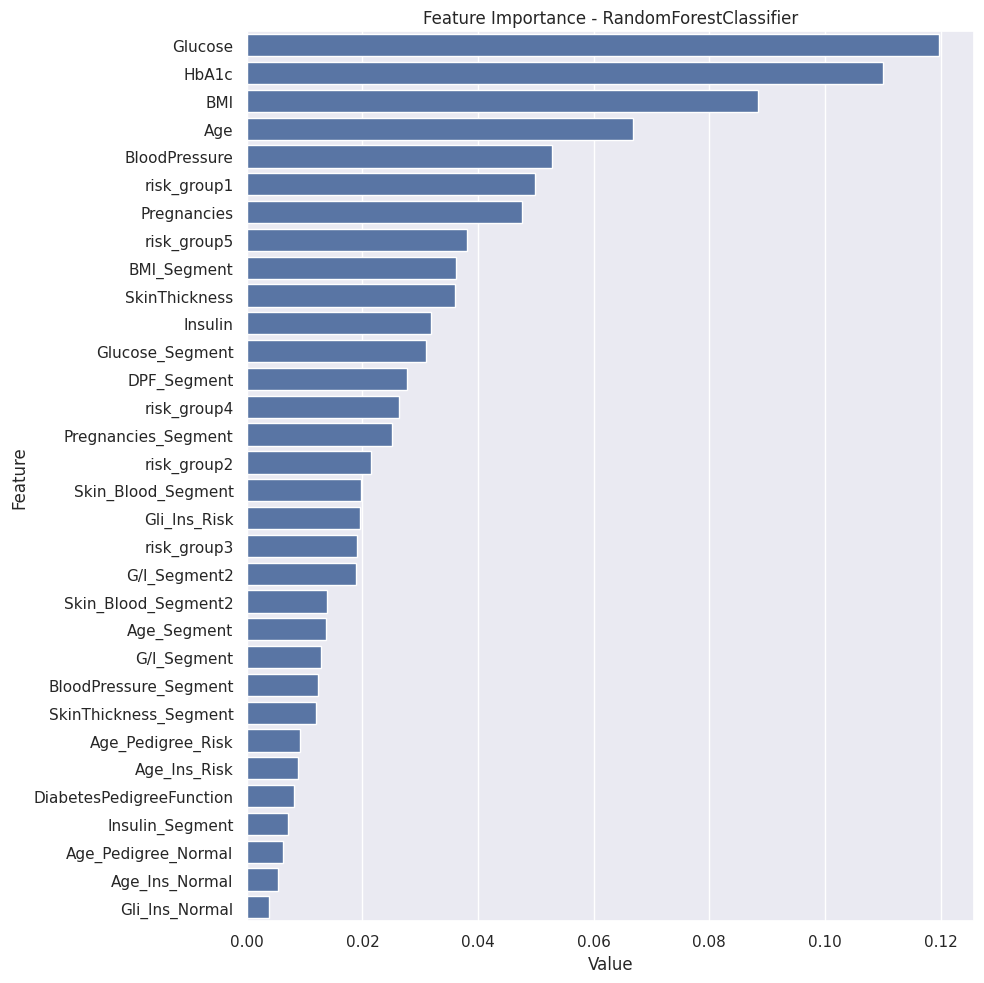

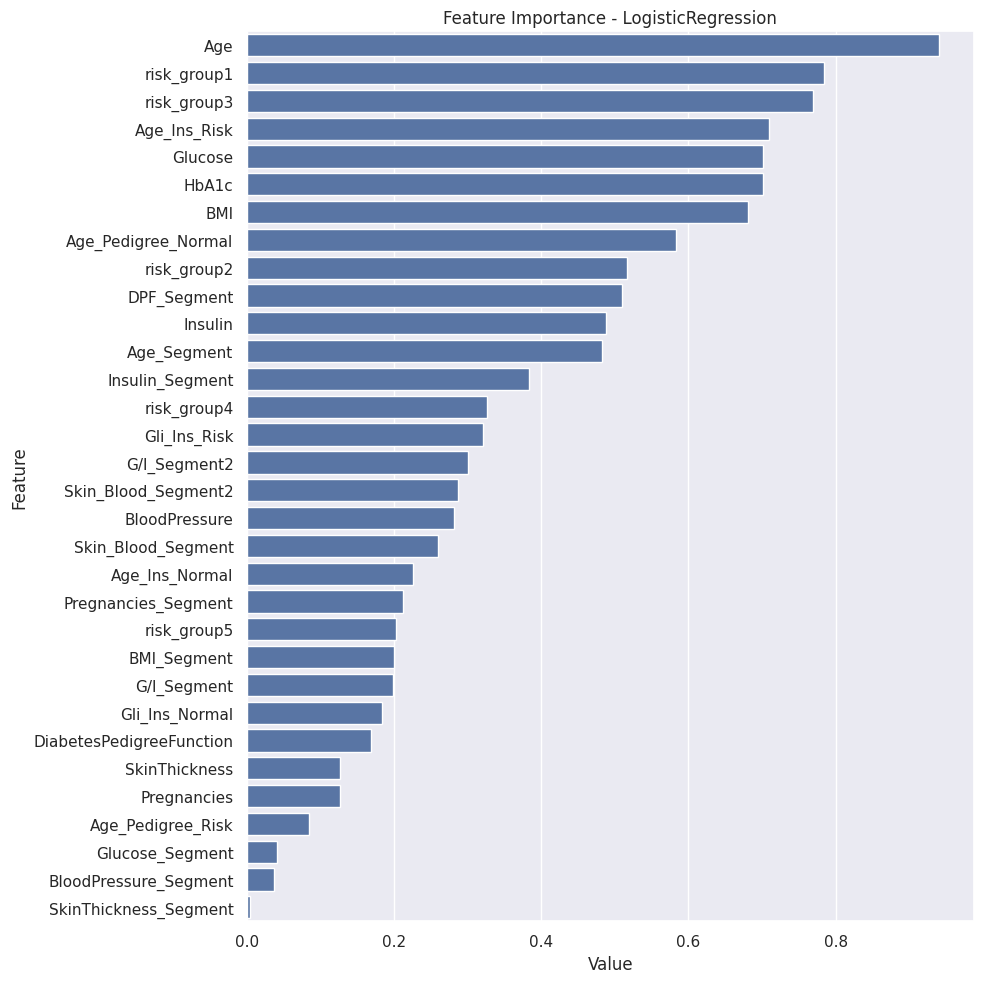

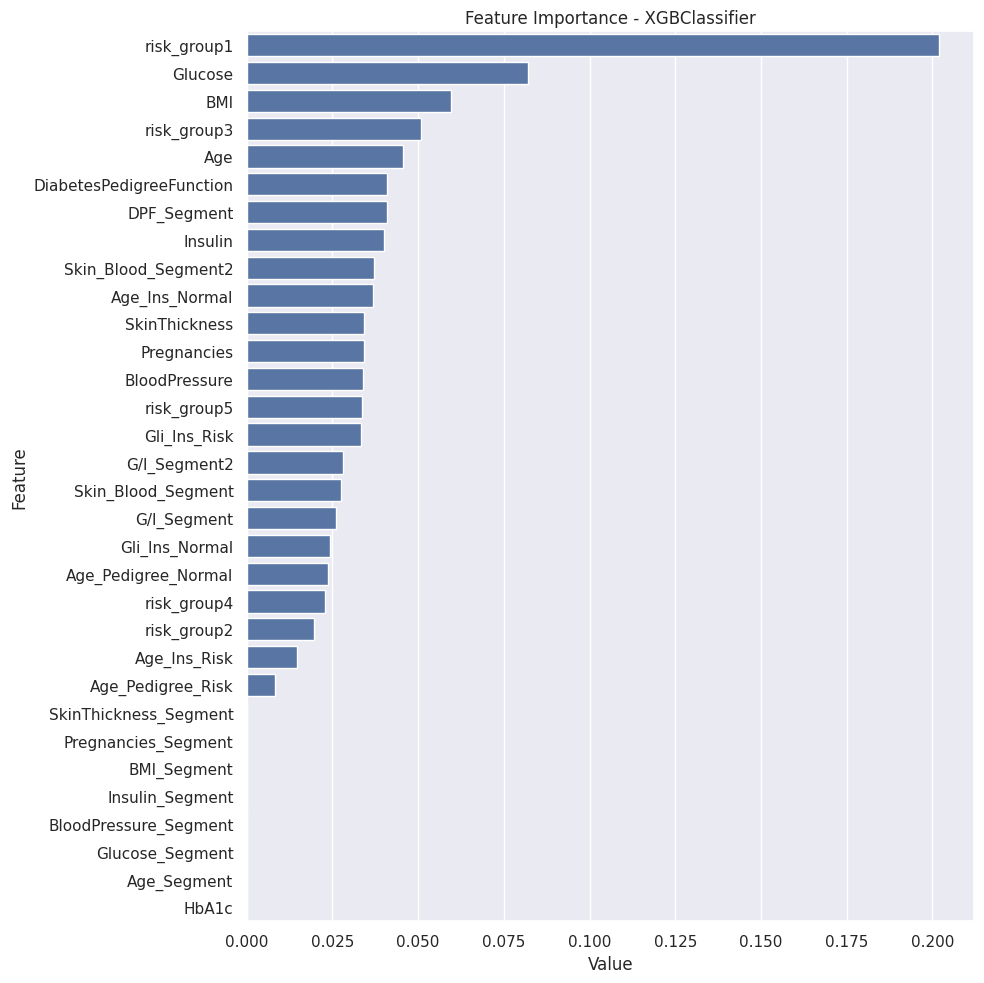

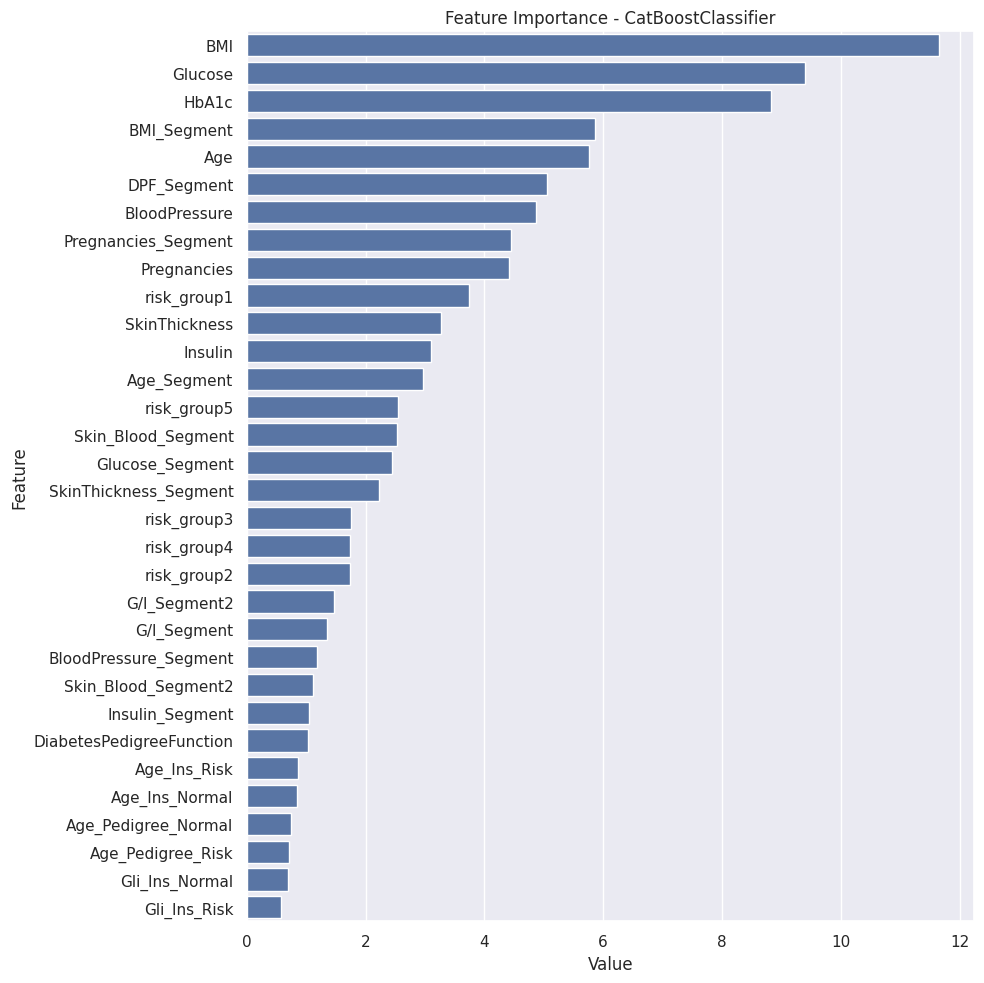

In [137]:
def plot_importance(model, features, num=None, save=False):
    if num is None:
        num = len(features.columns)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0] if model.coef_.ndim == 2 else model.coef_
        importances = np.abs(importances)
    else:
        print(f"{model.__class__.__name__} modelinde özellik önem değerleri bulunamadı.")
        return

    feature_imp = pd.DataFrame({'Value': importances, 'Feature': features.columns})

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature",
                data=feature_imp.sort_values(by="Value", ascending=False).iloc[:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')
    plt.show()

models = [RandomForestClassifier(),
          LogisticRegression(),
          XGBClassifier(),
          CatBoostClassifier(verbose=False, random_state=12345)
         ]

for model in models:
    model.fit(X, y)
    plot_importance(model, X)

# Hyperparameter Optimization

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=12345
)

param_grids = {
    "LR": {"C": [0.001, 0.01, 0.1, 1, 10, 100]},
    "KNN": {"n_neighbors": [3, 5, 7, 9], "weights": ['uniform', 'distance']},
    "CART": {"max_depth": [3, 5, 7, None], "min_samples_split": [2, 5, 10]},
    "RF": {"n_estimators": [100, 200], "max_depth": [5, 7, None], "min_samples_leaf": [1, 2]},
    "XGB": {"learning_rate": [0.01, 0.1], "max_depth": [3, 5], "subsample": [0.8, 1.0]},
    "LightGBM": {"num_leaves": [31, 63], "learning_rate": [0.01, 0.1], "n_estimators": [100, 200]},
    "CatBoost": {"iterations": [500], "depth": [4, 6], "learning_rate": [0.03, 0.1]}
}

def optimize_and_evaluate(models, param_grids):
    optimized_results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

    for model_info in models:
        name = model_info[0]
        model = model_info[1]

        print(f"\n⏳ {name} Optimization...")

        try:
            if name not in param_grids:
                raise ValueError(f"{name} no parametre grid")

            gs = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=skf,
                scoring='accuracy',
                n_jobs=-1,
                verbose=0
            ).fit(X_train, y_train)

            final_model = gs.best_estimator_
            y_pred = final_model.predict(X_test)
            y_proba = final_model.predict_proba(X_test)[:,1] if hasattr(final_model, "predict_proba") else None

            metrics = {
                "Model": name,
                "Best Params": gs.best_params_,
                "Test Accuracy": round(accuracy_score(y_test, y_pred), 4),
                "Test AUC": round(roc_auc_score(y_test, y_proba), 4) if y_proba is not None else "N/A",
                "Test F1": round(f1_score(y_test, y_pred), 4),
                "Test Precision": round(precision_score(y_test, y_pred), 4),
                "Test Recall": round(recall_score(y_test, y_pred), 4)
            }

            optimized_results.append(metrics)
            print(f"✅ {name} completed | Best accuracy: {metrics['Test Accuracy']}")

        except Exception as e:
            print(f"❌ {name} error: {str(e)}")
            continue

    return pd.DataFrame(optimized_results)

param_grids = {
    "LR": {"C": [0.001, 0.01, 0.1, 1, 10, 100]},
    "KNN": {"n_neighbors": [3, 5, 7, 9], "weights": ['uniform', 'distance']},
    "CART": {"max_depth": [3, 5, 7, None], "min_samples_split": [2, 5, 10]},
    "RF": {"n_estimators": [100, 200], "max_depth": [5, 7, None], "min_samples_leaf": [1, 2]},
    "XGB": {"learning_rate": [0.01, 0.1], "max_depth": [3, 5], "subsample": [0.8, 1.0]},
    "CatBoost": {"iterations": [500], "depth": [4, 6], "learning_rate": [0.03, 0.1]}
}

models_to_optimize = [
    ("LR", LogisticRegression(random_state=12345, max_iter=1000)),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier(random_state=12345)),
    ("RF", RandomForestClassifier(random_state=12345, n_jobs=-1)),
    ("XGB", XGBClassifier(random_state=12345, n_jobs=-1)),
    ("CatBoost", CatBoostClassifier(random_state=12345, verbose=False))
]

optimized_df = optimize_and_evaluate(
    models=models_to_optimize,
    param_grids=param_grids
)


⏳ LR Optimization...
✅ LR completed | Best accuracy: 0.7662

⏳ KNN Optimization...
✅ KNN completed | Best accuracy: 0.8117

⏳ CART Optimization...
✅ CART completed | Best accuracy: 0.7468

⏳ RF Optimization...
✅ RF completed | Best accuracy: 0.7922

⏳ XGB Optimization...
✅ XGB completed | Best accuracy: 0.7922

⏳ CatBoost Optimization...
✅ CatBoost completed | Best accuracy: 0.7727


# Final Model

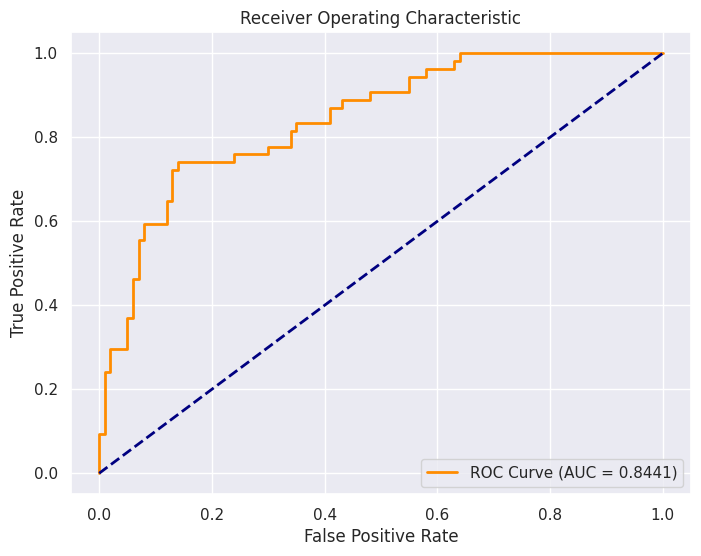

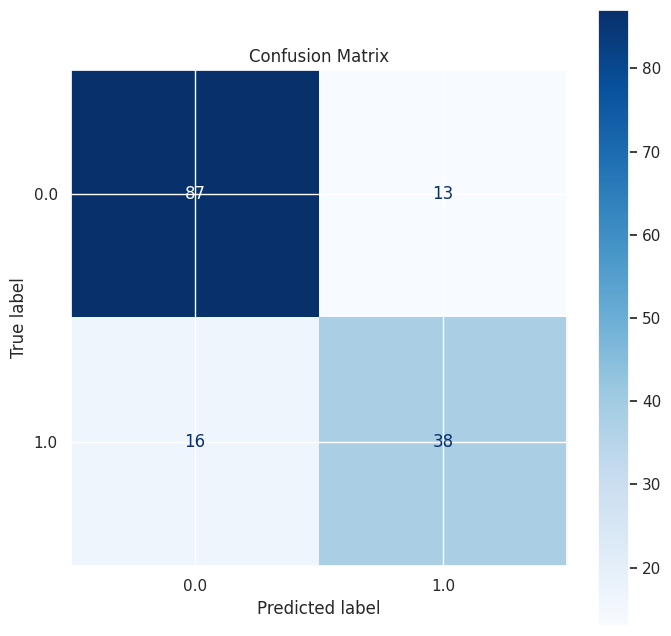

Final Model Performance on Test Set
-------------------------------------
Accuracy : 0.8117
Recall   : 0.7037
Precision: 0.7451
F1 Score : 0.7238
AUC      : 0.8441


In [139]:
best_row = optimized_df.loc[optimized_df['Test Accuracy'].idxmax()]
model_name = best_row['Model']
best_params = best_row['Best Params']

base_model = None
for name, model in models_to_optimize:
    if name == model_name:
        base_model = model
        break
if base_model is None:
    raise ValueError(f"Model {model_name} not found in models_to_optimize")

from sklearn.base import clone
best_model = clone(base_model)
best_model.set_params(**best_params)

best_model.fit(X_train, y_train)

y_final_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_final_pred)
recall = recall_score(y_test, y_final_pred)
precision = precision_score(y_test, y_final_pred)
f1 = f1_score(y_test, y_final_pred)
auc_score = roc_auc_score(y_test, y_proba)

print("Final Model Performance on Test Set")
print("-------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc_score:.4f}")